In [40]:
import os
from datetime import datetime

from IPython.display import SVG
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset  # pylint:disable=no-name-in-module
from shapely.geometry import Point

In [41]:
nc = Dataset(
    os.path.join(
        os.environ["HOME"],
        "Documents",
        "eocis",
        "landice_dash_test",
        "data_files",
        "EOCIS-AIS-L3C-SEC-MULTIMISSION-5KM-5YEAR-MEANS-201705-202205-fv1.nc",
    )
)

In [42]:
for k, v in nc.variables.items():
    print(k, "\n", v)
    print()

sec 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec(time_period, ny, nx)
    long_name: surface elevation change
    units: m/yr
    source: multi-mission radar altimetry
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 968, 1128)
filling on, default _FillValue of 9.969209968386869e+36 used

sec_uncertainty 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec_uncertainty(time_period, ny, nx)
    long_name: uncertainty in surface elevation change
    units: m/yr
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 968, 1128)
filling on, default _FillValue of 9.969209968386869e+36 used

x 
 <class 'netCDF4._netCDF4.Variable'>
float32 x(nx)
    long_name: Cartesian x-coordinate - easting, of centre of each grid cell
    units: meters
    standard_name: projection_x_coordinate
    min_val: -2817500.0
    binsize: 5000.0
unlimited dimensions: 
current shape = (1128,)
filling on, default _FillValue of 9.969209968386869e+36 used

y 
 <class '

In [43]:
x_values: np.ndarray = nc["x"][:].data
y_values: np.ndarray = nc["y"][:].data
lat: np.ndarray = nc["lat"][:].data
lon: np.ndarray = nc["lon"][:].data
surf_type: np.ndarray = nc["surface_type"][:].data
sec: np.ndarray = np.squeeze(nc["sec"][:].data)

x_coords, y_coords = np.meshgrid(x_values, y_values, indexing="xy")

print(x_values.shape, y_values.shape)
print(x_coords.shape, y_coords.shape, sec.shape, surf_type.shape)

(1128,) (968,)
(968, 1128) (968, 1128) (968, 1128) (968, 1128)


In [44]:
coords_arr = [Point(x, y) for x, y in zip(x_coords.flatten(), y_coords.flatten())]
sec_arr = sec.flatten()
surf_type_arr = surf_type.flatten()

print(len(coords_arr), sec_arr.shape, surf_type_arr.shape)

1091904 (1091904,) (1091904,)


In [45]:
np.unique(surf_type)

array([0, 1, 2, 3, 4], dtype=int8)

In [46]:
my_data = gpd.GeoDataFrame(
    data={
        "SEC": sec_arr,
        "surface type": surf_type_arr,
        "geometry": coords_arr,
    },
    crs="epsg:3031",
)
my_data.head()

,SEC,surface type,geometry
0,NaN,0,POINT (-2817500.000 -2417500.000)
1,NaN,0,POINT (-2812500.000 -2417500.000)
2,NaN,0,POINT (-2807500.000 -2417500.000)
3,NaN,0,POINT (-2802500.000 -2417500.000)
4,NaN,0,POINT (-2797500.000 -2417500.000)


In [47]:
sum(my_data["SEC"].isna())

720313

In [64]:
ais_basins = gpd.read_file("aux_files/IMBIE_AIS_Basins/ANT_Basins_IMBIE2_v1.6.shp")
ais_basins = ais_basins.reset_index().rename(columns={"index": "basin_id"})
ais_basins.head()

,basin_id,Regions,Subregion,geometry
0,0,Islands,None,"MULTIPOLYGON (((2404549.605 -824175.129, 24052..."
1,1,West,H-Hp,"POLYGON ((-1747055.814 -7497.327, -1749638.686..."
2,2,West,F-G,"POLYGON ((-914638.723 -1276047.570, -914860.99..."
3,3,East,E-Ep,"POLYGON ((-239862.180 -442192.806, -242322.167..."
4,4,East,D-Dp,"POLYGON ((1453579.447 -2047575.392, 1453837.89..."


In [49]:
sf_type = 1
marker_size = 1

/tmp/ipykernel_54441/662768454.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


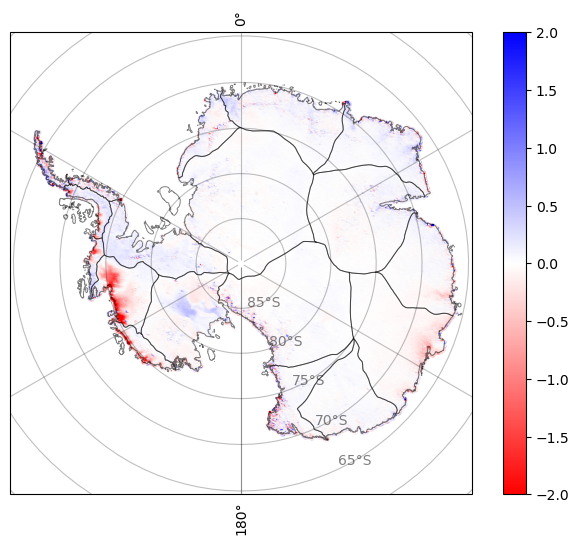

In [50]:
crs_3031 = ccrs.Stereographic(central_latitude=-90, true_scale_latitude=-71)
transformed = my_data.to_crs(crs_3031)

fig, ax = plt.subplots(
    figsize=(8, 6), facecolor="white", subplot_kw=dict(projection=crs_3031)
)  # Create our plot

transformed[transformed["SEC"].notna()].plot(
    column="SEC",
    ax=ax,
    legend=True,
    vmax=2,
    vmin=-2,
    marker="s",
    markersize=marker_size,
    cmap="bwr_r",
)

ais_basins.plot(color="none", edgecolor="black", ax=ax, alpha=0.5, lw=0.7)

# ax.coastlines(resolution="50m", color="black")  # Add coastlines
gl = ax.gridlines(draw_labels=True, color="black", alpha=0.25)
gl.ylabel_style = {
    "color": "black",
    "alpha": 0.5,
}
ax.set_xlim(-2.8e6, 2.8e6)
ax.set_ylim(-2.8e6, 2.8e6)

fig.show()

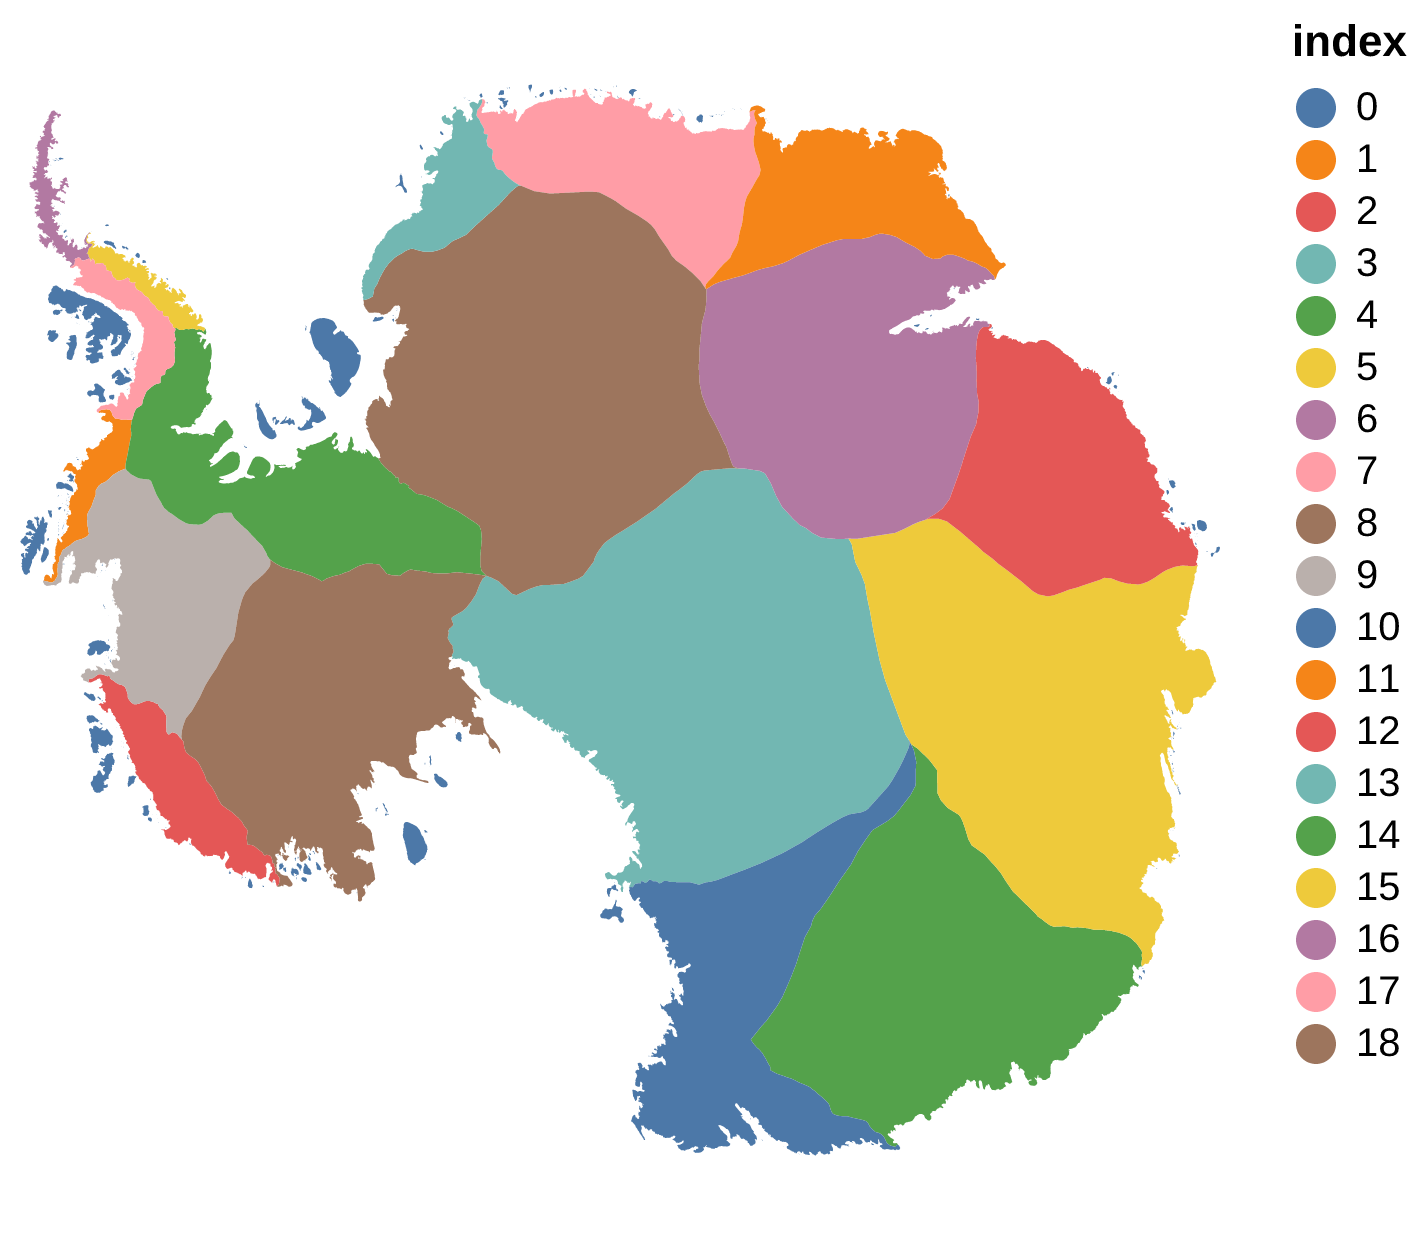

In [61]:
import altair as alt
import vl_convert as vlc
import json
from IPython.display import Image

click_state = alt.selection_point(fields=["basin_id"])

map = (
    alt.Chart(
        ais_basins.reset_index().to_crs("epsg:4326"),
    )
    .mark_geoshape()
    .encode(color="basin_id:N", opacity=alt.condition(click_state, alt.value(1), alt.value(0.2)))
    .project(type="stereographic")
)


vg_spec = chart.to_json()
with open("altair_chart.vg.json", "wt") as f:
    json.dump(vg_spec, f)

png_data = vlc.vegalite_to_png(chart.to_json(), scale=4)
Image(png_data, retina=True)